In [1]:
include("cosmology_vars.jl")
include("nu_osc_params.jl")

using DelimitedFiles
using Plots
using Interpolations
using LaTeXStrings
using QuadGK
using SpecialFunctions
using BenchmarkTools
using Polynomials;

In [2]:
function F0_tint_func(F0vec::Vector{Float64})
    es = range(0, 100, 2000)
    F0int_ne = Interpolations.interpolate((vec(es),), F0vec, Gridded(Linear()))
    return extrapolate(F0int_ne, 0.0)
end

F0s_vec = readdlm("F0s_vec.txt", comments=true)

F0_νe_270sm, F0_νebar_270sm, F0_νx_270sm = F0_tint_func(vec(F0s_vec[:, 1])), F0_tint_func(vec(F0s_vec[:, 2])), F0_tint_func(vec(F0s_vec[:, 3]))
F0_νe_112sm, F0_νebar_112sm, F0_νx_112sm = F0_tint_func(vec(F0s_vec[:, 4])), F0_tint_func(vec(F0s_vec[:, 5])), F0_tint_func(vec(F0s_vec[:, 6]))
F0_νe_bh, F0_νebar_bh, F0_νx_bh = F0_tint_func(vec(F0s_vec[:, 7])), F0_tint_func(vec(F0s_vec[:, 8])), F0_tint_func(vec(F0s_vec[:, 9]))

function F0(E, β, sm)
    if β == "e" && sm == "small"
        return F0_νe_112sm(E)
    elseif β == "e" && sm == "large"
        return F0_νe_270sm(E)
    elseif β == "e" && sm == "bh"
        return F0_νe_bh(E)
    elseif β == "ebar" && sm == "small"
        return F0_νebar_112sm(E)
    elseif β == "ebar" && sm == "large"
        return F0_νebar_270sm(E)
    elseif β == "ebar" && sm == "bh"
        return F0_νebar_bh(E)   
    elseif β == "x" && sm == "small"
        return F0_νx_112sm(E)
    elseif β == "x" && sm == "large"
        return F0_νx_270sm(E)
    elseif β == "x" && sm == "bh"
        return F0_νx_bh(E)
    else
        return 0
    end
end

# Oscillations thru the SN medium
# Accounting for oscillations thru the SN medium

s12 = 0.297
c12 = 1 - s12
PH = 0

# ordering = "NO" (normal ordering) or "IO" (inverted ordering)
function F(E, β, sm, ordering)
    if ordering == "NO"
        if β == "e"
            return F0(E, "x", sm)
        elseif β == "ebar"
            return c12*F0(E, "ebar", sm) + s12*F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(F0(E, "e", sm) + F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(s12*F0(E, "ebar", sm) + (1 + c12)*F0(E, "x", sm))
        else
            return 0
        end
    elseif ordering == "IO"
        if β == "e"
            return s12*F0(E, "e", sm) + c12*F0(E, "x", sm)
        elseif β == "ebar"
            return F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(c12*F0(E, "e", sm) + (1 + s12)*F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(F0(E, "ebar", sm) + F0(E, "x", sm))
        else
            return 0
        end
    else
        return 0
    end
end

# In the mass basis now: i = 1, 2, 3, nubar = true or false
function Fmass_old(E, i, sm, ordering, nubar)
    if nubar==false
        return Usqred(ordering)[1, i]*F(E, "e", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "x", sm, ordering)
    elseif nubar==true
        return Usqred(ordering)[1, i]*F(E, "ebar", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "xbar", sm, ordering)
    else
        return 0
    end
end;

In [3]:
function Fmass_tint_func(i, sm, ordering, nubar)
    es = range(0, 100, 2000)
    Fmassint_ne = Interpolations.interpolate((vec(es),), Fmass_old.(es, i, sm, ordering, nubar), Gridded(Linear()))
    return extrapolate(Fmassint_ne, 0.0)
end

Fm_1_112sm_NO_nu = Fmass_tint_func(1, "small", "NO", false)
Fm_1_112sm_NO_nubar = Fmass_tint_func(1, "small", "NO", true)
Fm_1_112sm_IO_nu = Fmass_tint_func(1, "small", "IO", false)
Fm_1_112sm_IO_nubar = Fmass_tint_func(1, "small", "IO", true)
Fm_1_270sm_NO_nu = Fmass_tint_func(1, "large", "NO", false)
Fm_1_270sm_NO_nubar = Fmass_tint_func(1, "large", "NO", true)
Fm_1_270sm_IO_nu = Fmass_tint_func(1, "large", "IO", false)
Fm_1_270sm_IO_nubar = Fmass_tint_func(1, "large", "IO", true)
Fm_1_bh_NO_nu = Fmass_tint_func(1, "bh", "NO", false)
Fm_1_bh_NO_nubar = Fmass_tint_func(1, "bh", "NO", true)
Fm_1_bh_IO_nu = Fmass_tint_func(1, "bh", "IO", false)
Fm_1_bh_IO_nubar = Fmass_tint_func(1, "bh", "IO", true)

Fm_2_112sm_NO_nu = Fmass_tint_func(2, "small", "NO", false)
Fm_2_112sm_NO_nubar = Fmass_tint_func(2, "small", "NO", true)
Fm_2_112sm_IO_nu = Fmass_tint_func(2, "small", "IO", false)
Fm_2_112sm_IO_nubar = Fmass_tint_func(2, "small", "IO", true)
Fm_2_270sm_NO_nu = Fmass_tint_func(2, "large", "NO", false)
Fm_2_270sm_NO_nubar = Fmass_tint_func(2, "large", "NO", true)
Fm_2_270sm_IO_nu = Fmass_tint_func(2, "large", "IO", false)
Fm_2_270sm_IO_nubar = Fmass_tint_func(2, "large", "IO", true)
Fm_2_bh_NO_nu = Fmass_tint_func(2, "bh", "NO", false)
Fm_2_bh_NO_nubar = Fmass_tint_func(2, "bh", "NO", true)
Fm_2_bh_IO_nu = Fmass_tint_func(2, "bh", "IO", false)
Fm_2_bh_IO_nubar = Fmass_tint_func(2, "bh", "IO", true)

Fm_3_112sm_NO_nu = Fmass_tint_func(3, "small", "NO", false)
Fm_3_112sm_NO_nubar = Fmass_tint_func(3, "small", "NO", true)
Fm_3_112sm_IO_nu = Fmass_tint_func(3, "small", "IO", false)
Fm_3_112sm_IO_nubar = Fmass_tint_func(3, "small", "IO", true)
Fm_3_270sm_NO_nu = Fmass_tint_func(3, "large", "NO", false)
Fm_3_270sm_NO_nubar = Fmass_tint_func(3, "large", "NO", true)
Fm_3_270sm_IO_nu = Fmass_tint_func(3, "large", "IO", false)
Fm_3_270sm_IO_nubar = Fmass_tint_func(3, "large", "IO", true)
Fm_3_bh_NO_nu = Fmass_tint_func(3, "bh", "NO", false)
Fm_3_bh_NO_nubar = Fmass_tint_func(3, "bh", "NO", true)
Fm_3_bh_IO_nu = Fmass_tint_func(3, "bh", "IO", false)
Fm_3_bh_IO_nubar = Fmass_tint_func(3, "bh", "IO", true)

function Fmass_test1(E, sm, ordering, nubar)
    if sm == "small"
        if ordering == "NO"
            if nubar == false
                return Fm_1_112sm_NO_nu(E)
            elseif nubar == true
                return Fm_1_112sm_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_1_112sm_IO_nu(E)
            elseif nubar == true
                return Fm_1_112sm_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    elseif sm == "large"
        if ordering == "NO"
            if nubar == false
                return Fm_1_270sm_NO_nu(E)
            elseif nubar == true
                return Fm_1_270sm_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_1_270sm_IO_nu(E)
            elseif nubar == true
                return Fm_1_270sm_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    elseif sm == "bh"
        if ordering == "NO"
            if nubar == false
                return Fm_1_bh_NO_nu(E)
            elseif nubar == true
                return Fm_1_bh_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_1_bh_IO_nu(E)
            elseif nubar == true
                return Fm_1_bh_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    else
        return 0.0
    end
end
function Fmass_test2(E, sm, ordering, nubar)
    if sm == "small"
        if ordering == "NO"
            if nubar == false
                return Fm_2_112sm_NO_nu(E)
            elseif nubar == true
                return Fm_2_112sm_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_2_112sm_IO_nu(E)
            elseif nubar == true
                return Fm_2_112sm_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    elseif sm == "large"
        if ordering == "NO"
            if nubar == false
                return Fm_2_270sm_NO_nu(E)
            elseif nubar == true
                return Fm_2_270sm_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_2_270sm_IO_nu(E)
            elseif nubar == true
                return Fm_2_270sm_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    elseif sm == "bh"
        if ordering == "NO"
            if nubar == false
                return Fm_2_bh_NO_nu(E)
            elseif nubar == true
                return Fm_2_bh_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_2_bh_IO_nu(E)
            elseif nubar == true
                return Fm_2_bh_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    else
        return 0.0
    end
end
function Fmass_test3(E, sm, ordering, nubar)
    if sm == "small"
        if ordering == "NO"
            if nubar == false
                return Fm_3_112sm_NO_nu(E)
            elseif nubar == true
                return Fm_3_112sm_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_3_112sm_IO_nu(E)
            elseif nubar == true
                return Fm_3_112sm_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    elseif sm == "large"
        if ordering == "NO"
            if nubar == false
                return Fm_3_270sm_NO_nu(E)
            elseif nubar == true
                return Fm_3_270sm_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_3_270sm_IO_nu(E)
            elseif nubar == true
                return Fm_3_270sm_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    elseif sm == "bh"
        if ordering == "NO"
            if nubar == false
                return Fm_3_bh_NO_nu(E)
            elseif nubar == true
                return Fm_3_bh_NO_nubar(E)
            else
                return 0.0
            end
        elseif ordering == "IO"
            if nubar == false
                return Fm_3_bh_IO_nu(E)
            elseif nubar == true
                return Fm_3_bh_IO_nubar(E)
            else
                return 0.0
            end
        else
            return 0.0
        end
    else
        return 0.0
    end
end

function Fmass(E, i, sm, ordering, nubar)
    if i == 1
        return Fmass_test1(E, sm, ordering, nubar)
    elseif i == 2
        return Fmass_test2(E, sm, ordering, nubar)
    elseif i == 3
        return Fmass_test3(E, sm, ordering, nubar)
    else
        return 0.0
    end
end;

In [4]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
function DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end

# Mass method
DSNB(E, z0, i, nubar, ordering, bh_frac, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]

# νe method
function DSNB(E, z0, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB(E, z0, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB(E, z0, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB(E, z0, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [5]:
@time DSNB(1, 0, 1, true, "IO", "21", SNRnorm)

  1.363716 seconds (550.75 k allocations: 37.190 MiB, 3.49% gc time, 99.96% compilation time)


0.7095897823701633

In [6]:
# Separating the progenitors: 1pc ≡ one progenitor contribution

function DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)
    c0 = 3e8 # m s^(-1)
    # Adding in this integrated mass function so we can multiply by bh fractions at the end
    return 0.00208 * ηAD(125, 8) * (c0*normchoice*SFR(z)/Hubble(z)) * Fmass(E*(1+z)/(1+z0), i, sm, ordering, nubar)
end

DSNB_1pc(E, z0, i, nubar, ordering, sm, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice), z0, 5, rtol=1e-2)[1]

function DSNB_1pc(E, z0, nubar, ordering, sm, normchoice)
    ν1 = DSNB_1pc(E, z0, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_1pc(E, z0, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_1pc(E, z0, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [7]:
# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
leff = extrapolate(leff_ne, 0.0)

function decay(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(leff(z) - leff(z0))*(1+z0)/E)
end;

In [10]:
leff(1)

0.00587198999598493

In [12]:
xsvec = range(0, 5, 100)
leffsvec = 70*leff.(xsvec)

@time p = Polynomials.fit(xsvec, leffsvec, 14)

  0.264354 seconds (110.66 k allocations: 7.568 MiB, 94.48% compilation time)


Polynomial(3.844126829887412e-6 + 0.9994711237154343*x - 1.2171757160998375*x^2 + 1.2011732904692138*x^3 - 1.0258795580085436*x^4 + 0.7535135022231549*x^5 - 0.4576091931617817*x^6 + 0.2207326320476638*x^7 - 0.0820545498767346*x^8 + 0.022953521018636694*x^9 - 0.004712524469463747*x^10 + 0.0006858791896371295*x^11 - 6.682066367256103e-5*x^12 + 3.9015397017829775e-6*x^13 - 1.0310563080271216e-7*x^14)

In [13]:
function lefftest(x) 
    if x == 0.0
        return 0.0
    else
        (3.844126829887412e-6 + 0.9994711237154343*x - 1.2171757160998375*x^2 + 1.2011732904692138*x^3 - 1.0258795580085436*x^4 + 0.7535135022231549*x^5 - 0.4576091931617817*x^6 + 0.2207326320476638*x^7 - 0.0820545498767346*x^8 + 0.022953521018636694*x^9 - 0.004712524469463747*x^(10) + 0.0006858791896371295*x^(11) - 6.682066367256103e-5*x^(12) + 3.9015397017829775e-6*x^(13) - 1.0310563080271216e-7*x^(14))/70
    end
end;

In [18]:
function decaytest(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(lefftest(z) - lefftest(z0))*(1+z0)/E)
end

decaytest (generic function with 1 method)

In [23]:
@time decay(1, 10^(-26), 0.1, 1)

  0.000021 seconds (9 allocations: 144 bytes)


0.09355817485923254

In [8]:
# Invisible decay

# mass method
function DSNB_idecay(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
end

# νe method
function DSNB_idecay(E, z0, α1, α2, α3, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB_idecay(E, z0, α1, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, z0, α2, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, z0, α3, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end

# Single progenitor versions
function DSNB_idecay_1pc(E, z0, α, i, nubar, ordering, sm, normchoice)
    return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
end

function DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, sm, normchoice)
    ν1 = DSNB_idecay_1pc(E, z0, α1, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_idecay_1pc(E, z0, α2, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_idecay_1pc(E, z0, α3, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [9]:
function choicez(E, α, z0)
    innerpart = 0.007+(E/(4.68e28*α))*log(0.01*exp(-4.68e28*α*lefftest(z0)/E))
    if innerpart > 0.0
        return -0.555*(log(350*(innerpart))-0.9)
    else
        return 0.0
    end
end

choicez (generic function with 1 method)

In [10]:
function DSNB_idecay_test(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    zcut = choicez(E, α, z0)
    if zcut > z0 && zcut < 5 && decaytest(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decaytest(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decaytest(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    end
end

DSNB_idecay_test (generic function with 1 method)

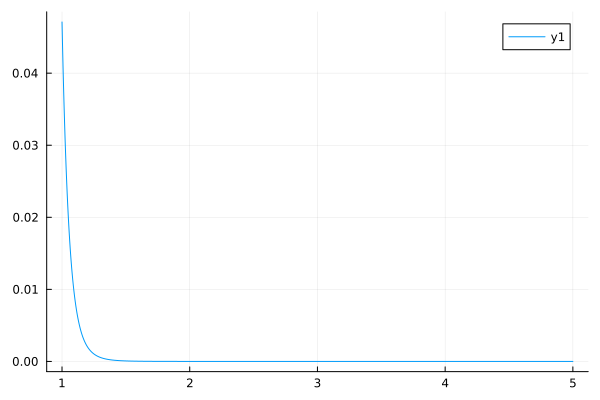

In [525]:
z0test = 1
zseval = range(z0test, 5, 1000)
plot(
    zseval,
    [DSNB_integrand.(1, z0test, zseval, 1, true, "IO", "21", SNRnorm) .* decaytest.(1, 10^(-25), z0test, zseval)]
)

In [32]:
@btime DSNB_idecay(1, 0, 10^(-24), 1, true, "IO", "21", SNRnorm)

  200.103 μs (5826 allocations: 92.14 KiB)


1.2833064466885395e-5

In [31]:
@time DSNB_idecay_test(10, 0, 10^(-27), 1, true, "IO", "21", SNRnorm)

  0.000255 seconds (1.79 k allocations: 28.938 KiB)


0.5451731370514598

In [36]:
@time DSNB_idecay_1pc(10, 0, 10^(-24), 10^(-24), 10^(-24), true, "IO", "small", SNRnorm)

  0.000710 seconds (7.27 k allocations: 116.078 KiB)


0.00269849397528066

In [11]:
# Energy spectrum function for SH case
function ψSH(Eh, El, hc)
    if hc
        return 2*El/Eh^2
    else
        return (2/Eh)*(1-(El/Eh))
    end
end;

In [12]:
# 2ν SH treatment assuming the smallest mass state has a mass of ≈0 (so all channels are SH except for IO ν2 → ν1, which is QD)

# We take m_j > m_i
function qcontrib_2ν(E, z0, z, j, jbar, i, ibar, αj, ordering, bh_frac, normchoice)

    if ordering == "NO" && j <= i
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 1 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 1
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 2 && i == 1
        if jbar != ibar
            return 0.0
        else
            Ers = E*(1+z)/(1+z0)
            qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
            return qnorm * (c0/Hubble(z))*DSNB_idecay(Ers, z, αj, j, jbar, ordering, bh_frac, normchoice) * (αj/Ers)
        end
    else
        if jbar == ibar
            hc = true
        else
            hc = false
        end

        Ers = E*(1+z)/(1+z0)

        qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
        integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, αj, j, jbar, ordering, bh_frac, normchoice) * (αj * 0.5/Eprime) * ψSH(Eprime, Ers, hc)
        Emax = Ers + 50

        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
end

function DSNB_vdecay_2ν(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if αj == 0
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, αj, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, αj, i, ibar, "IO", bh_frac, normchoice)
    else
        # Here, for NO we take ν2 to be stable and for IO we take ν1 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 3, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 3, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 2, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 2, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice) + qint
    end
end;

# Other few cases where the heaviest mass state and lightest mass state are stable, and the middle mass state decays into the lightest mass state
function DSNB_vdecay_2ν_alt(E, αj, i, ibar, ordering, bh_frac, normchoice)
    if αj == 0
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice)
    elseif ordering == "NO" && i == 2
        return DSNB_idecay(E, 0, αj, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 1
        return DSNB_idecay(E, 0, αj, i, ibar, "IO", bh_frac, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay(E, 0, 0, i, ibar, "NO", bh_frac, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay(E, 0, 0, i, ibar, "IO", bh_frac, normchoice)
    else
        # Here, for NO we take ν1 to be stable and for IO we take ν2 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 2, false, i, ibar, αj, "NO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 2, true, i, ibar, αj, "NO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν(E, 0, z, 1, false, i, ibar, αj, "IO", bh_frac, normchoice)+qcontrib_2ν(E, 0, z, 1, true, i, ibar, αj, "IO", bh_frac, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay(E, 0, 0, i, ibar, ordering, bh_frac, normchoice) + qint
    end
end

# daughter specifies the state the heaviest mass state decays into in our 2ν framework
function DSNB_vdecay_2ν_νe(E, α, daughter, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        if daughter == 1
            α1, α2, α3 = α, 0.0, α
        elseif daughter == 2
            α1, α2, α3 = 0.0, α, α
        else
            return println("error: for NO, 'daughter' must be either ν1 or ν2")
        end
    elseif ordering == "IO"
        if daughter == 3
            α3, α1, α2 = α, 0.0, α
        elseif daughter == 1
            α3, α1, α2 = 0.0, α, α
        else
            return println("error: for IO, 'daughter' must be either ν1 or ν3")
        end
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2ν(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_2ν(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

# If we don't specify a daughter, the decay channel is assumed to be from the second lightest to the lightest state
function DSNB_vdecay_2ν_νe(E, α, ebar, ordering, bh_frac, normchoice)
    if ordering == "NO"
        α1, α2, α3 = α, α, 0.0
    elseif ordering == "IO"
        α1, α2, α3 = α, 0.0, α
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν_alt(E, α3, 3, ebar, ordering, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2ν_alt(E, α2, 2, ebar, ordering, bh_frac, normchoice)
    ν1 = DSNB_vdecay_2ν_alt(E, α1, 1, ebar, ordering, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end


# Single progenitor versions
function qcontrib_2ν_1pc(E, z0, z, j, jbar, i, ibar, αj, ordering, sm, normchoice)

    if ordering == "NO" && j <= i
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 1 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 1
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 3 && i == 2
        return println("error: not kinematically allowed")
    elseif ordering == "IO" && j == 2 && i == 1
        if jbar != ibar
            return 0.0
        else
            Ers = E*(1+z)/(1+z0)
            qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
            return qnorm * (c0/Hubble(z))*DSNB_idecay_1pc(Ers, z, αj, j, jbar, ordering, sm, normchoice) * (αj/Ers)
        end
    else
        if jbar == ibar
            hc = true
        else
            hc = false
        end

        Ers = E*(1+z)/(1+z0)

        qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
        integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_idecay_1pc(Eprime, z, αj, j, jbar, ordering, sm, normchoice) * (αj * 0.5/Eprime) * ψSH(Eprime, Ers, hc)
        Emax = Ers + 50

        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
end

function DSNB_vdecay_2ν_1pc(E, αj, i, ibar, ordering, sm, normchoice)
    if αj == 0
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, ordering, sm, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay_1pc(E, 0, αj, i, ibar, "NO", sm, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay_1pc(E, 0, αj, i, ibar, "IO", sm, normchoice)
    else
        # Here, for NO we take ν2 to be stable and for IO we take ν1 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν_1pc(E, 0, z, 3, false, i, ibar, αj, "NO", sm, normchoice)+qcontrib_2ν_1pc(E, 0, z, 3, true, i, ibar, αj, "NO", sm, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν_1pc(E, 0, z, 2, false, i, ibar, αj, "IO", sm, normchoice)+qcontrib_2ν_1pc(E, 0, z, 2, true, i, ibar, αj, "IO", sm, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, ordering, sm, normchoice) + qint
    end
end;

# Other few cases where the heaviest mass state and lightest mass state are stable, and the middle mass state decays into the lightest mass state
function DSNB_vdecay_2ν_alt_1pc(E, αj, i, ibar, ordering, sm, normchoice)
    if αj == 0
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, ordering, sm, normchoice)
    elseif ordering == "NO" && i == 2
        return DSNB_idecay_1pc(E, 0, αj, i, ibar, "NO", sm, normchoice)
    elseif ordering == "IO" && i == 1
        return DSNB_idecay_1pc(E, 0, αj, i, ibar, "IO", sm, normchoice)
    elseif ordering == "NO" && i == 3
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, "NO", sm, normchoice)
    elseif ordering == "IO" && i == 2
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, "IO", sm, normchoice)
    else
        # Here, for NO we take ν1 to be stable and for IO we take ν2 to be stable, and we take the lightest mass states to be stable as well
        if ordering == "NO"
            qint = quadgk(z -> (qcontrib_2ν_1pc(E, 0, z, 2, false, i, ibar, αj, "NO", sm, normchoice)+qcontrib_2ν_1pc(E, 0, z, 2, true, i, ibar, αj, "NO", sm, normchoice)), 0, 5, rtol=1e-2)[1]
        elseif ordering == "IO"
            qint = quadgk(z -> (qcontrib_2ν_1pc(E, 0, z, 1, false, i, ibar, αj, "IO", sm, normchoice)+qcontrib_2ν_1pc(E, 0, z, 1, true, i, ibar, αj, "IO", sm, normchoice)), 0, 5, rtol=1e-2)[1]
        else
            return println("error: ordering takes either 'NO' or 'IO'")
        end
        return DSNB_idecay_1pc(E, 0, 0, i, ibar, ordering, sm, normchoice) + qint
    end
end

# daughter specifies the state the heaviest mass state decays into in our 2ν framework
function DSNB_vdecay_2ν_νe_1pc(E, α, daughter, ebar, ordering, sm, normchoice)
    if ordering == "NO"
        if daughter == 1
            α1, α2, α3 = α, 0.0, α
        elseif daughter == 2
            α1, α2, α3 = 0.0, α, α
        else
            return println("error: for NO, 'daughter' must be either ν1 or ν2")
        end
    elseif ordering == "IO"
        if daughter == 3
            α3, α1, α2 = α, 0.0, α
        elseif daughter == 1
            α3, α1, α2 = 0.0, α, α
        else
            return println("error: for IO, 'daughter' must be either ν1 or ν3")
        end
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν_1pc(E, α3, 3, ebar, ordering, sm, normchoice)
    ν2 = DSNB_vdecay_2ν_1pc(E, α2, 2, ebar, ordering, sm, normchoice)
    ν1 = DSNB_vdecay_2ν_1pc(E, α1, 1, ebar, ordering, sm, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

# If we don't specify a daughter, the decay channel is assumed to be from the second lightest to the lightest state
function DSNB_vdecay_2ν_νe_1pc(E, α, ebar, ordering, sm, normchoice)
    if ordering == "NO"
        α1, α2, α3 = α, α, 0.0
    elseif ordering == "IO"
        α1, α2, α3 = α, 0.0, α
    else
        return println("error: ordering must take either 'NO' or 'IO'")
    end
    ν3 = DSNB_vdecay_2ν_alt_1pc(E, α3, 3, ebar, ordering, sm, normchoice)
    ν2 = DSNB_vdecay_2ν_alt_1pc(E, α2, 2, ebar, ordering, sm, normchoice)
    ν1 = DSNB_vdecay_2ν_alt_1pc(E, α1, 1, ebar, ordering, sm, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end;

In [52]:
@time DSNB_vdecay_2ν_νe_1pc(10, 10^(-26), true, "NO", "small", SNRnorm)

  0.020845 seconds (285.98 k allocations: 4.540 MiB)


0.48179810478336715

In [10]:
# Trying to use HCubature to speed up the double integral
#=
using HCubature
function DSNB_vdecay_2ν_IO_2to3_1pc_hcube(E, α2, threebar, sm, normchoice)
    if threebar == true
        hcs = [true, false]
    else
        hcs = [false, true]
    end
    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(z, u) = (1+z) * qnorm * (c0/Hubble(z)) * (α2 * 0.5/(u*(1+z))) * (DSNB_idecay_1pc(u*(1+z), z, α2, 2, true, "IO", sm, normchoice)*ψSH(u*(1+z), E*(1+z), hcs[1])
        + DSNB_idecay_1pc(u*(1+z), z, α2, 2, false, "IO", sm, normchoice)*ψSH(u*(1+z), E*(1+z), hcs[2]))
    return hcubature(x -> integrand(x[1], x[2]), [0, E], [5, E+50], rtol=1e-2)[1] + DSNB_idecay_1pc(E, 0, 0, 3, threebar, "IO", sm, SNRnorm)
end
=#

In [13]:
# 3ν NO SH treatment

function branch_3ν_NO(j, i)
    if j == 3
        return 0.25
    elseif j == 2
        return 0.5
    else
        return println("error: j is not a valid index")
    end
end

function DSNB_vdecay_3_NO(E, z0, α3, threebar, bh_frac, normchoice)
    function decay_integrand(E, z0, z, α3, threebar, bh_frac, normchoice)
        if α3 == 0
            return DSNB_integrand(E, z0, z, 3, threebar, "NO", bh_frac, normchoice)
        else
            int = DSNB_integrand(E, z0, z, 3, threebar, "NO", bh_frac, normchoice)*decay(E, α3, z0, z) 
            if isnan(int) || isinf(int)
                return 0.0
            else
                return int
            end
        end
    end
    return 1/(1+z0) * quadgk(z -> decay_integrand(E, z0, z, α3, threebar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end

function q3icontrib_NO(E, z0, z, α3, threebar, i, ibar, bh_frac, normchoice)
    if threebar == ibar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_3_NO(Eprime, z, α3, threebar, bh_frac, normchoice) * (α3 * branch_3ν_NO(3, i)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end

function DSNB_vdecay_2_NO(E, z0, α3, α2, twobar, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, z0, z, 2, twobar, "NO", bh_frac, normchoice) +
                          q3icontrib_NO(E, z0, z, α3, true, 2, twobar, bh_frac, normchoice) + q3icontrib_NO(E, z0, z, α3, false, 2, twobar, bh_frac, normchoice))*decay(E, α2, z0, z)
    return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
end

function q21contrib_NO(E, z0, z, α3, α2, twobar, onebar, bh_frac, normchoice)
    if twobar == onebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NO(Eprime, z, α3, α2, twobar, bh_frac, normchoice) * (α2 * branch_3ν_NO(2, 1)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end

# z0 is always 0 here because we're only concerned with the flux at Earth
function DSNB_vdecay_1_NO(E, α3, α2, onebar, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 1, onebar, "NO", bh_frac, normchoice)
                    + q21contrib_NO(E, 0, z, α3, α2, true, onebar, bh_frac, normchoice)
                    + q21contrib_NO(E, 0, z, α3, α2, false, onebar, bh_frac, normchoice)
                    + q3icontrib_NO(E, 0, z, α3, true, 1, onebar, bh_frac, normchoice)
                    + q3icontrib_NO(E, 0, z, α3, false, 1, onebar, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_NO(E, α3, α2, nubar, bh_frac, normchoice)
    ν3 = DSNB_vdecay_3_NO(E, 0, α3, nubar, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2_NO(E, 0, α3, α2, nubar, bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_NO(E, α3, α2, nubar, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end;  

In [84]:
@time DSNB_vdecay_1_NO(1, 10^(-24), 10^(-24), true, "21", SNRnorm)

400.822085 seconds (7.25 G allocations: 110.824 GiB, 8.47% gc time, 2.54% compilation time)


8.44135630458028

In [59]:
@time q3icontrib_NO(1, 0.1, 0.2, 10^(-24), true, 2, true, "21", SNRnorm)

  0.004224 seconds (43.40 k allocations: 690.000 KiB)


0.047070546344859396

In [76]:
@time DSNB_vdecay_2_NO(10, 0.1, 10^(-24), 10^(-24), true, "21", SNRnorm)

  0.297391 seconds (5.15 M allocations: 80.585 MiB, 7.91% gc time)


0.005133702035382023

In [83]:
@time q21contrib_NO(1, 0.1, 0.2, 10^(-24), 10^(-24), true, true, "21", SNRnorm)

 23.498237 seconds (444.97 M allocations: 6.776 GiB, 14.25% gc time)


0.36047986830227596

In [ ]:
es_dsnb = range(0.01, 40, 100);

In [ ]:
dsnb_vdecay_NO_1 = DSNB_vdecay_3ν_νe_NO(E, α3, α2, nubar, bh_frac, normchoice)

In [15]:
@time DSNB_vdecay_1_NO(1, 10^(-24), 10^(-24), true, "21", SNRnorm)

500.684965 seconds (7.24 G allocations: 110.334 GiB, 10.31% gc time)


8.44135630458028

In [16]:
@time DSNB_vdecay_3ν_νe_NO(1, 10^(-24), 10^(-24), true, "21", SNRnorm)

515.944643 seconds (7.26 G allocations: 110.567 GiB, 10.40% gc time)


5.634062428462369

In [299]:
@time DSNB_vdecay_3ν_νe_NO(10, 10^(-25), 10^(-25), true, "21", SNRnorm)

349.165829 seconds (4.54 G allocations: 68.988 GiB, 12.24% gc time, 0.09% compilation time)


0.5746870673894012

In [304]:
10000/60/24

6.944444444444444

In [301]:
527*0.75 / 60

6.5875

In [293]:
@time DSNB_vdecay_1_NO(1, 10^(-25), 10^(-25), true, "21", SNRnorm)

 69.107062 seconds (901.97 M allocations: 13.762 GiB, 12.01% gc time)


8.14333841213382

In [14]:
# 3ν IO treatment (2 → 1 QD, 2/1 → 3 SH)

# Case A
# ν2 → ν1, ν2 → ν3, no ν1 → ν3:
# B_21 = 0.5 (no hf), B_23 = 0.25, B_13 = 0
# NB: here if we want to only consider visible decays, we should set α1 to 0 always

# Case B
# ν2 → ν1, ν1 → ν3, no ν2 → ν3:
# B_21 = 1 (no hf), B_13 = 0.5, B_23 = 0

# Case C
# ν2 → ν3, ν1 → ν3, no ν2 → ν1
# B_23 = 0.5, B_13 = 0.5, B_21 = 0

# Democratic
# ν2 → ν3, ν1 → ν3, ν2 → ν1
# B_21 = B_23 = 1/3, B_13 = 0.5

# Note: supposing validity of SH and QD approximations, branching ratios are set in B and C

function branching_3ν(casechoice, j, jbar, i, ibar)
    if casechoice == "A"
        if j == 2 && i == 1 && jbar == ibar
            return 0.5
        elseif j == 2 && i == 3
            return 0.25
        else
            return 0.0
        end
    elseif casechoice == "B"
        if j == 2 && i == 1 && jbar == ibar
            return 1.0
        elseif j == 1 && i == 3
            return 0.5
        else 
            return 0.0
        end
    elseif casechoice == "C"
        if j == 2 && i == 3
            return 0.5
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    elseif casechoice == "democratic"
        if (j == 2 && i == 1 && jbar == ibar) || (j == 2 && i == 3)
            return 1/3
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    else
        return 0.0
    end
end

function DSNB_vdecay_2_IO(E, z0, α2, twobar, bh_frac, normchoice)
    function decay_integrand(E, z0, z, α2, twobar, bh_frac, normchoice)
        if α2 == 0
            return DSNB_integrand(E, z0, z, 2, twobar, "IO", bh_frac, normchoice)
        else
            int = DSNB_integrand(E, z0, z, 2, twobar, "IO", bh_frac, normchoice)*decay(E, α2, z0, z) 
            if isnan(int) || isinf(int)
                return 0.0
            else
                return int
            end
        end
    end
    return 1/(1+z0) * quadgk(z -> decay_integrand(E, z0, z, α2, twobar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end

function q21contrib_IO(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z)) * DSNB_vdecay_2_IO(Ers, z, α2, nubar, bh_frac, normchoice) * (α2 * branching_3ν(casechoice, 2, nubar, 1, nubar)/Ers)
end

function DSNB_vdecay_1_IO(E, z0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    if casechoice == "A"
        α1 = 0
    end
    integrand(z) = (DSNB_integrand(E, z0, z, 1, nubar, "IO", bh_frac, normchoice) +
                        q21contrib_IO(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice))*decay(E, α1, z0, z)
    return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
end

function q23contrib_IO(E, z0, z, α2, twobar, threebar, casechoice, bh_frac, normchoice)

    if twobar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_IO(Eprime, z, α2, twobar, bh_frac, normchoice) * (α2 * branching_3ν(casechoice, 2, twobar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
end

function q13contrib_IO(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    #=
    if Emax > 100
        return quadgk(Eprime -> integrand(Eprime), Ers, 100, Inf, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
    =#
    return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
end

function q13contrib_IO_test(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    #=
    if Emax > 100
        return quadgk(Eprime -> integrand(Eprime), Ers, 100, Inf, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
    =#
    return quadgk(u -> integrand(u*(1+z))*(1+z), E/(1+z0), (E/(1+z0))+50, rtol=1e-2)[1]
end

function DSNB_vdecay_3_IO(E, α2, α1, threebar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 3, threebar, "IO", bh_frac, normchoice)
                    + q23contrib_IO(E, 0, z, α2, true, threebar, casechoice, bh_frac, normchoice)
                    + q23contrib_IO(E, 0, z, α2, false, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO(E, 0, z, α2, α1, true, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO(E, 0, z, α2, α1, false, threebar, casechoice, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_IO(E, α2, α1, nubar, casechoice, bh_frac, normchoice)

    ν3 = DSNB_vdecay_3_IO(E, α2, α1, nubar, casechoice, bh_frac, normchoice)
    ν2 = DSNB_vdecay_2_IO(E, 0, α2, nubar, bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_IO(E, 0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    
    return Usqred("IO")[1, 1]*ν1 + Usqred("IO")[1, 2]*ν2 + Usqred("IO")[1, 3]*ν3
end;

In [22]:
@time DSNB_vdecay_3ν_νe_IO(1, 10^(-25), 10^(-25), false, "D", "21", SNRnorm)

  1.056438 seconds (17.63 M allocations: 276.482 MiB, 11.31% gc time)


0.02120063892514524

In [23]:
es_dsnb = range(0.5, 40, 100);

In [24]:
@time DSNB_vdecay_3ν_νe_IO.(es_dsnb, 10^(-25), 10^(-25), false, "D", "21", SNRnorm)

387.917666 seconds (4.83 G allocations: 73.695 GiB, 8.66% gc time, 2.91% compilation time)


100-element Vector{Float64}:
 0.006264532757169715
 0.017982285289065227
 0.03028671762605343
 0.04036773145693192
 0.047606075483071005
 0.05242924534015282
 0.0555804176346547
 0.05780793892265453
 0.059740507184516387
 0.06183070817822498
 0.06433976742644767
 0.06734490235933971
 0.07076258619941692
 ⋮
 0.0018293597993189101
 0.0017131577910345437
 0.0016046979614875317
 0.0015034417583564795
 0.0014088936491952616
 0.0013205983315883326
 0.001238123126637793
 0.0011610706988901232
 0.0010890736643364787
 0.001021783316265251
 0.0009588789207534943
 0.0009000648243712296

In [25]:
@time DSNB_vdecay_3ν_νe_IO.(es_dsnb, 10^(-24), 10^(-24), false, "D", "21", SNRnorm)

517.987997 seconds (5.66 G allocations: 86.058 GiB, 8.15% gc time)


100-element Vector{Float64}:
 0.006250506605716625
 0.017885166737910647
 0.029961195484852862
 0.03958374303007562
 0.04604224502796402
 0.049660647217664694
 0.051058035943495145
 0.050844330958723045
 0.04952614619977818
 0.047494290254025726
 0.045037216042303034
 0.042361606964423114
 0.039586412919087766
 ⋮
 0.00042165280070970135
 0.0003996374390827053
 0.0003787936591097276
 0.000359060933835747
 0.00034038091128869575
 0.0003226968619586744
 0.00030595623017054535
 0.00029010954094783046
 0.0002751092213419033
 0.000260909882217145
 0.00024746850071451047
 0.00023474358065359656

In [329]:
@time DSNB_vdecay_3ν_νe_IO(30, 10^(-26), 10^(-26), true, "B", "21", SNRnorm)

  3.950665 seconds (49.04 M allocations: 762.712 MiB, 11.49% gc time)


0.00825212820807668

In [26]:
@time DSNB_vdecay_3ν_νe_NO(0.5, 10^(-24), 10^(-24), true, "21", SNRnorm)

1223.814537 seconds (11.76 G allocations: 186.676 GiB, 11.19% gc time, 17.73% compilation time)


6.8108765562560505

In [27]:
@time DSNB_vdecay_3ν_νe_NO(5, 10^(-24), 10^(-24), true, "21", SNRnorm)

171.075115 seconds (2.02 G allocations: 30.977 GiB, 11.42% gc time, 4.61% compilation time)


2.107137363737836

In [28]:
@time DSNB_vdecay_3ν_νe_NO(40, 10^(-24), 10^(-24), true, "21", SNRnorm)

175.000902 seconds (2.37 G allocations: 36.000 GiB, 11.69% gc time)


0.0010850550363596346

In [15]:
# Function to save an N-dimensional array to a text file
function save_array_nd(array, filename)
    array2d = reshape(array, size(array, 1), prod(size(array)[2:end]))
    writedlm(filename, array2d)
end

# Function to load an N-dimensional array from a text file
# For dims, input size(array), where "array" was what you originally read into the text file
function load_array_nd(filename, dims)
    read_array2d = readdlm(filename, Int)
    reshaped_array = reshape(read_array2d, dims)
    return reshaped_array
end;

In [16]:
es_dsnb = range(0.5, 40, 100);

In [33]:
dsnb_vdecay_complete = DSNB_vdecay_2ν_νe.(es_dsnb, 10^(-24), 1, false, "NO", "21", SNRnorm)
dsnb_vdecay_partial = DSNB_vdecay_2ν_νe.(es_dsnb, 10^(-26), 1, false, "NO", "21", SNRnorm)
dsnb_nodecay = DSNB.(es_dsnb, 0, false, "NO", "21", SNRnorm);

In [39]:
length(-26:0.2:-24)

11

In [48]:
nubars = [false, true]
progenitors = ["small", "large", "bh"]
es = range(0.5, 40, 100)
logαs = -26:0.2:-24
αs = 10 .^ logαs

# Inverted ordering
dsnb_IO_2to1_matrix = [DSNB_vdecay_2ν_νe_1pc(E, α, 1, bar, "IO", sm, SNRnorm) for bar in nubars, sm in progenitors, α in αs, E in es]
dsnb_IO_2to3_matrix = [DSNB_vdecay_2ν_νe_1pc(E, α, 3, bar, "IO", sm, SNRnorm) for bar in nubars, sm in progenitors, α in αs, E in es]
dsnb_IO_1to3_matrix = [DSNB_vdecay_2ν_νe_1pc(E, α, bar, "IO", sm, SNRnorm) for bar in nubars, sm in progenitors, α in αs, E in es]

# Normal ordering
dsnb_NO_3to2_matrix = [DSNB_vdecay_2ν_νe_1pc(E, α, 2, bar, "NO", sm, SNRnorm) for bar in nubars, sm in progenitors, α in αs, E in es]
dsnb_NO_3to1_matrix = [DSNB_vdecay_2ν_νe_1pc(E, α, 1, bar, "NO", sm, SNRnorm) for bar in nubars, sm in progenitors, α in αs, E in es]
dsnb_NO_2to1_matrix = [DSNB_vdecay_2ν_νe_1pc(E, α, bar, "NO", sm, SNRnorm) for bar in nubars, sm in progenitors, α in αs, E in es];

In [49]:
dsnb_matrices = cat(dsnb_IO_2to1_matrix, dsnb_IO_2to3_matrix, dsnb_IO_1to3_matrix, dsnb_NO_3to2_matrix, dsnb_NO_3to1_matrix, dsnb_NO_2to1_matrix, dims=5)

save_array_nd(dsnb_matrices, "dsnb_2nu_matrices_test.txt");